In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# -----------------------------
# 1. Data Acquisition
# -----------------------------
db_file = "shopping_data.db"  # assign file
engine = create_engine(f"sqlite:///{db_file}")  # SQLite connection

# Read data directly using the SQLAlchemy engine
df = pd.read_sql("SELECT * FROM shopping", engine)
print("Initial Data Sample:")
print(df.head())

Initial Data Sample:
   InvoiceNo StockCode Description  Quantity       InvoiceDate  UnitPrice  \
0     221958  SKU_1964   White Mug        38  2020-01-01 00:00       1.71   
1     771155  SKU_1241   White Mug        18  2020-01-01 01:00      41.25   
2     231932  SKU_1501  Headphones        49  2020-01-01 02:00      29.11   
3     465838  SKU_1760   Desk Lamp        14  2020-01-01 03:00      76.68   
4     359178  SKU_1386   USB Cable       -30  2020-01-01 04:00     -68.11   

   CustomerID         Country  Discount  PaymentMethod  ShippingCost  \
0     37039.0       Australia  0.470000  Bank Transfer         10.79   
1     19144.0           Spain  0.190000        paypall          9.51   
2     50472.0         Germany  0.350000  Bank Transfer         23.03   
3     96586.0     Netherlands  0.140000        paypall         11.08   
4         NaN  United Kingdom  1.501433  Bank Transfer           NaN   

      Category SalesChannel  ReturnStatus ShipmentProvider WarehouseLocation  \
0  


Summary statistics:
           InvoiceNo      Quantity          InvoiceDate     UnitPrice  \
count   49782.000000  49782.000000                49782  49782.000000   
mean   550681.239946     22.372343  2022-11-03 02:30:00     47.537862   
min    100005.000000    -50.000000  2020-01-01 00:00:00    -99.980000   
25%    324543.000000     11.000000  2021-06-02 13:15:00     23.592500   
50%    552244.000000     23.000000  2022-11-03 02:30:00     48.920000   
75%    776364.000000     37.000000  2024-04-04 15:45:00     74.610000   
max    999997.000000     49.000000  2025-09-05 05:00:00    100.000000   
std    260703.009944     17.917774                  NaN     33.479510   

         CustomerID      Discount  ShippingCost    TotalSales  
count  49782.000000  49782.000000  49782.000000  49782.000000  
mean   55032.871775      0.275748     17.494529    874.038420  
min    10001.000000      0.000000      5.000000  -4492.538818  
25%    35163.250000      0.130000     11.540000    220.559100  
5

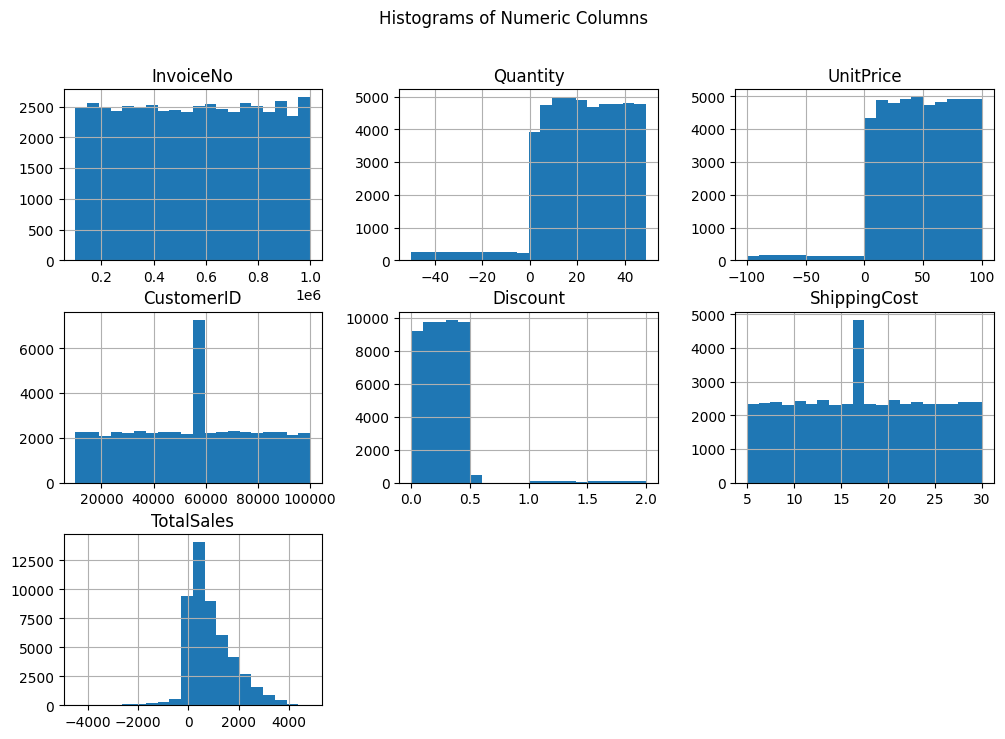

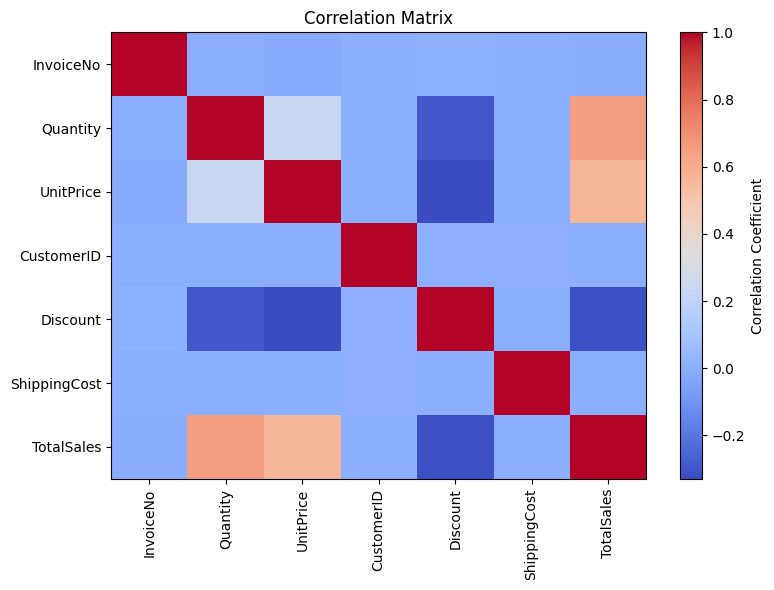

In [22]:
# -----------------------------
# 2. Data Exploration (EDA)
# -----------------------------

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Data information: datatypes
print("\nDataset information:")
print(df.info())

# Identify missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Plot histograms for numeric columns to understand distributions
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Numeric Columns")
plt.show()

# Plot a correlation matrix using matplotlib
corr = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label="Correlation Coefficient")
plt.xticks(range(len(numeric_columns)), numeric_columns, rotation=90)
plt.yticks(range(len(numeric_columns)), numeric_columns)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### Observations:

<br>

- Histograms of Numeric Columns:
    - InvoiceNo appears to have a tight distribution (typical for an ID-like column).
    - Quantity ranges from negative to positive, suggesting possible returns (negative values) or data entry peculiarities.
    - UnitPrice spans a wide range; a few items may be much higher-priced or discounted heavily.
    - CustomerID shows a large range, indicating many unique customers.
    - Discount is primarily between 0 and 0.5, with a noticeable peak (e.g., around 0.2–0.3).
    - ShippingCost mostly clusters between 0 and 30.
    - TotalSales (calculated as Quantity * UnitPrice * (1 - Discount)) varies widely, reflecting both returns (negative/low values) and large orders (higher values).
    - Takeaway: The data spans multiple transaction types (including possible returns), and some columns exhibit outliers or wide distributions that may require special attention in analysis or modeling.
      
 <br>

- Correlation Matrix
    - Quantity and TotalSales show a moderate positive correlation (red indicates a positive relationship). This makes sense since total sales partly depends on quantity sold.
    - Discount and TotalSales have a slight negative correlation, suggesting that higher discounts can reduce total revenue.
    - ShippingCost does not strongly correlate with most other features, indicating it might depend on factors not captured (e.g., distance, item weight).
    - InvoiceNo and CustomerID show weak or near-zero correlations with other variables, behaving more like identifiers than predictive features.
    - Takeaway: Only a few pairs of features (especially those directly involved in the total sales calculation) show notable correlation, implying that many variables are relatively independent.

In [24]:
# -----------------------------
# 3. Data Cleaning & Preprocessing
# -----------------------------

# Convert the InvoiceDate column to datetime format
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    # Remove rows with invalid dates
    df = df[df['InvoiceDate'].notnull()]
    
# For numeric columns, fill missing values with the column mean
for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)
        print(f"Filled missing values in {col} with mean value {mean_val:.2f}")

# Fill categorical columns that have missing values with the mode or a placeholder
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Filled missing values in {col} with mode value {mode_val}")

# Parse date columns
if 'order_date' in df.columns:
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
    print("Parsed 'order_date' as datetime.")

# Create a new column for the year extracted from the 'order_date'
if 'order_date' in df.columns:
    df['order_year'] = df['order_date'].dt.year

In [25]:
# -----------------------------
# 4. Normalizing and Standardizing the Data
# -----------------------------

# Exclude columns that likely represent IDs
columns_to_scale = [col for col in numeric_columns if 'id' not in col.lower()]

# Standardized DataFrame (mean=0, std=1)
scaler_standard = StandardScaler()
df_standardized = df.copy()
df_standardized[columns_to_scale] = scaler_standard.fit_transform(df[columns_to_scale])
print("\nStandardized DataFrame:")
print(df_standardized[columns_to_scale].head())

# Normalized DataFrame ([0,1] range)
scaler_minmax = MinMaxScaler()
df_normalized = df.copy()
df_normalized[columns_to_scale] = scaler_minmax.fit_transform(df[columns_to_scale])
print("\nNormalized DataFrame:")
print(df_normalized[columns_to_scale].head())


Standardized DataFrame:
   InvoiceNo  Quantity  UnitPrice  Discount  ShippingCost  TotalSales
0  -1.260923  0.872196  -1.368847  0.844303     -0.952664   -0.915060
1   0.845698 -0.244025  -0.187814 -0.372696     -1.134543   -0.297115
2  -1.222665  1.486118  -0.550428  0.322732      0.786550    0.057889
3  -0.325443 -0.467269   0.870456 -0.590017     -0.911458    0.053610
4  -0.734572 -2.922956  -3.454322  5.327346      0.000000   -2.069259

Normalized DataFrame:
   InvoiceNo  Quantity  UnitPrice  Discount  ShippingCost  TotalSales
0   0.135505  0.888889   0.508501  0.235028      0.231600    0.484705
1   0.745729  0.686869   0.706221  0.095011      0.180400    0.545412
2   0.146587  1.000000   0.645515  0.175021      0.721200    0.580288
3   0.406485  0.646465   0.883388  0.070008      0.243200    0.579868
4   0.287973  0.202020   0.159366  0.750805      0.499781    0.371316


In [41]:
# -----------------------------
# 5. Data Integration
# -----------------------------

# Convert the 'Month' column to string for both standardized and normalized DataFrames
if 'Month' in df_standardized.columns:
    df_standardized['Month'] = df_standardized['Month'].astype(str)
if 'Month' in df_normalized.columns:
    df_normalized['Month'] = df_normalized['Month'].astype(str)
    
# Create a SQLAlchemy engine for a SQLite database (this creates a file called sales_data.db)
engine = create_engine('sqlite:///sales_data.db', echo=False)

# Write the standardized DataFrame to a new SQL table named 'sales_standardized'
table_name_standardized = 'sales_standardized'
try:
    df_standardized.to_sql(table_name_standardized, con=engine, if_exists='replace', index=False)
    print(f"Standardized data successfully loaded into the SQLite database table '{table_name_standardized}'.")
except Exception as e:
    print("Error loading standardized data into database:", e)

# Write the normalized DataFrame to a new SQL table named 'sales_normalized'
table_name_normalized = 'sales_normalized'
try:
    df_normalized.to_sql(table_name_normalized, con=engine, if_exists='replace', index=False)
    print(f"Normalized data successfully loaded into the SQLite database table '{table_name_normalized}'.")
except Exception as e:
    print("Error loading normalized data into database:", e)

Standardized data successfully loaded into the SQLite database table 'sales_standardized'.
Normalized data successfully loaded into the SQLite database table 'sales_normalized'.


In [52]:
# -----------------------------
# 6. Visualizations: Trends in Sales Data
# -----------------------------
sns.set_theme(style="whitegrid")
rocket_colors = sns.color_palette("rocket", n_colors=4)  # We'll use up to 4 colors

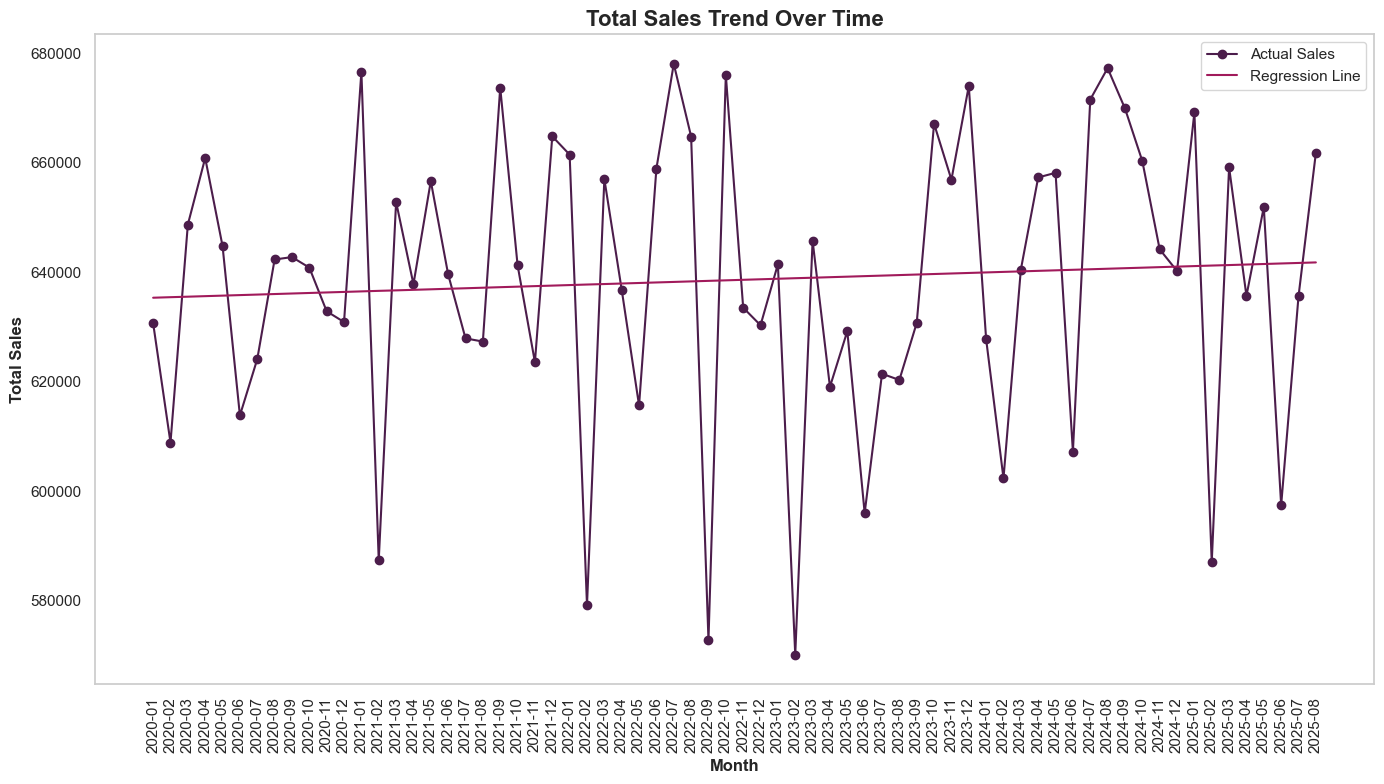

In [53]:
# 6.1 Total Sales Trend Over Time

# Total sales column addition to represent the effective sales value after discount
if 'TotalSales' not in df.columns:
    df['TotalSales'] = df['Quantity'] * df['UnitPrice'] * (1 - df['Discount'])

# Create a new column 'Month' from the InvoiceDate column
df['Month'] = df['InvoiceDate'].dt.to_period('M')

# Group the data by Month and calculate total sales per month
sales_trend = df.groupby('Month')['TotalSales'].sum().reset_index()

# Convert the 'Month' periods to strings for easier plotting
sales_trend['Month'] = sales_trend['Month'].astype(str)

# Remove the last row
sales_trend = sales_trend.iloc[:-1]


# Prepare data for regression

# Convert month strings to a numeric ordinal (days since 1/1/1970, for example)
sales_trend['Month_ordinal'] = pd.to_datetime(sales_trend['Month']).map(pd.Timestamp.toordinal)
X = sales_trend[['Month_ordinal']]
y = sales_trend['TotalSales']

# Fit a simple linear regression model
model = LinearRegression()
model.fit(X, y)

# Generate predictions
y_pred = model.predict(X)


# Plot Actual Data + Regression Line
plt.figure(figsize=(14,8))
plt.plot(sales_trend['Month'], sales_trend['TotalSales'], marker='o', label='Actual Sales', color=rocket_colors[0])
plt.plot(sales_trend['Month'], y_pred, label='Regression Line', color=rocket_colors[1])
plt.xticks(rotation=90)
plt.xlabel("Month", weight='bold')
plt.ylabel("Total Sales", weight='bold')
plt.title("Total Sales Trend Over Time", fontsize=16, weight='bold')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

#### Observations:
- Slight Upward Trend: The red regression line has a gentle positive slope, indicating that overall monthly total sales are increasing over time, although the increase is modest
- Significant Fluctuations Month-to-Month: The blue markers (actual sales) vary notably above and below the regression line. This suggests other factors—seasonality, promotions, economic shifts, etc.—may influence sales in individual months
- Overall Range of Sales: 
Most data points hover roughly between 600,000 and 700,000 in total sales each month. The data doesn’t show a dramatic or sustained dip/rise outside this band
- Volatility vs. Trend: While the trend line shows a gradual increase, the actual sales often spike or drop in ways that a simple linear model doesn’t fully capture, which indicates that month-to-month variations may be driven by complex factors beyond a basic linear pattern

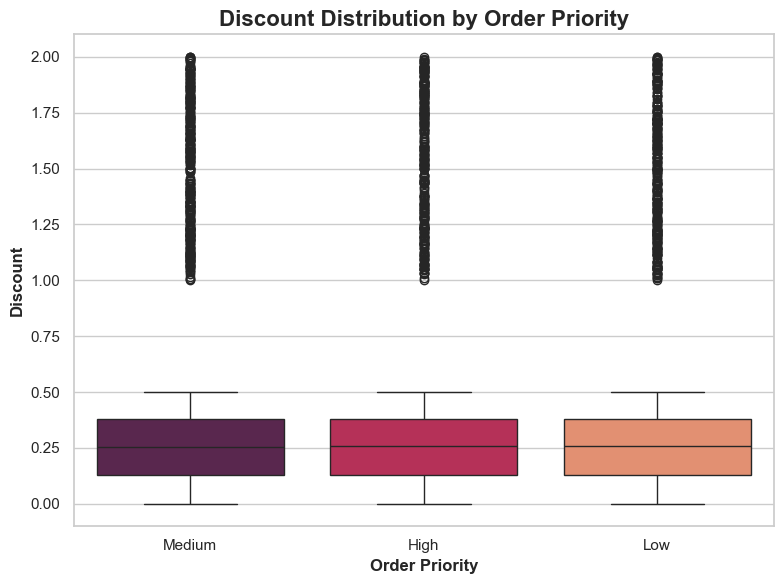

In [54]:
# 6.2 Discount Distribution by Order Priority
# Boxplot showing the distribution of discounts for each order priority category
plt.figure(figsize=(8,6))
sns.boxplot(x='OrderPriority', y='Discount', data=df, palette="rocket")
plt.xlabel("Order Priority", weight='bold')
plt.ylabel("Discount", weight='bold')
plt.title("Discount Distribution by Order Priority", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

#### Observations:
- All three categories appear to have a relatively similar median discount, but there are numerous high-discount outliers across each priority
- “Low” priority orders might have a slightly higher median discount than “Medium” or “High,” or vice versa—interpret based on the actual positions of the median lines
- The wide range of outliers suggests that, while most orders receive modest discounts, a subset of orders in each priority category receive much larger discounts

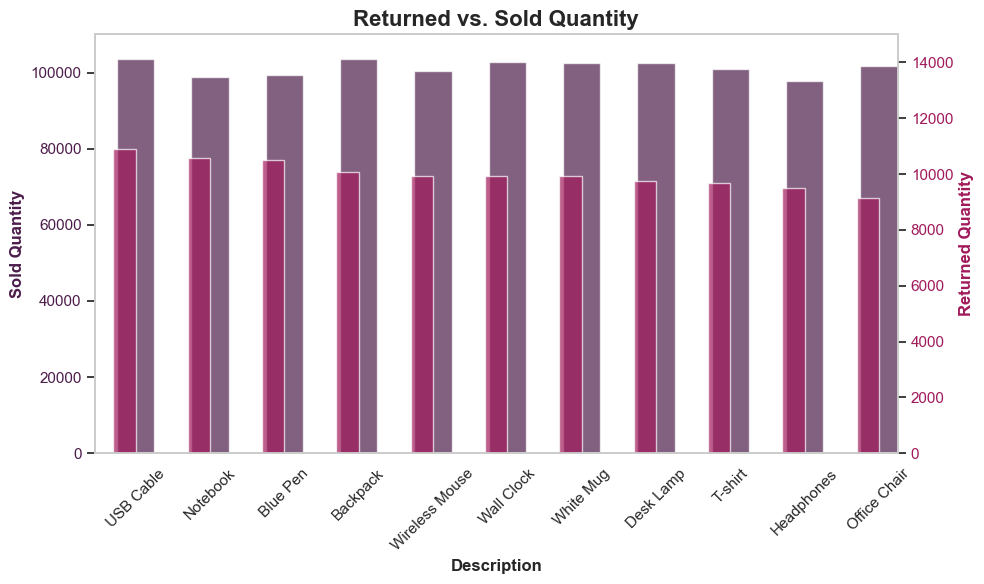

In [55]:
# 6.3 Returned vs. Sold Quantities (Dual-axis Bar Chart)

# Filter rows for returned items
returned_items = df[df['ReturnStatus'] == "Returned"]

# Sum the returned quantity by item (group by 'Description')
returned_sum = returned_items.groupby('Description')['Quantity'].sum()

# Sum the total sold quantity by the same grouping
sold_sum = df.groupby('Description')['Quantity'].sum()

# Combine them into a single DataFrame
combined = pd.DataFrame({
    'ReturnedQuantity': returned_sum,
    'SoldQuantity': sold_sum
})

# Sort by ReturnedQuantity and pick the top 10
combined_sort = combined.sort_values(by='ReturnedQuantity', ascending=False)
combined_sort

# Set a Seaborn theme
sns.set_theme(style="whitegrid")

# Create plot
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot sold quantity on the primary axis
ax1.set_xlabel("Item Description", weight='bold')
ax1.set_ylabel("Sold Quantity", color=rocket_colors[0], weight='bold')
combined_sort['SoldQuantity'].plot(kind='bar', ax=ax1, color=rocket_colors[0], alpha=0.7)
ax1.tick_params(axis='y', labelcolor=rocket_colors[0])
plt.xticks(rotation=45)

# Change the y-axis range for sold quantity, e.g. from 0 to 50000:
ax1.set_ylim(0, 110000)

# Create a secondary axis for returned quantity
ax2 = ax1.twinx()
ax2.set_ylabel("Returned Quantity", color=rocket_colors[1], weight='bold')
combined_sort['ReturnedQuantity'].plot(kind='bar', ax=ax2, color=rocket_colors[1], alpha=0.7, width=0.3, position=1)
ax2.tick_params(axis='y', labelcolor=rocket_colors[1])

# Change the y-axis range for returned quantity, e.g. from 0 to 10000:
ax2.set_ylim(0, 15000)

# Turn off gridlines on both axes
ax1.grid(False)
ax2.grid(False)

plt.title("Returned vs. Sold Quantity", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

#### Observations:
- Similar Sold Quantities Across Items: Most items appear to have a sold quantity in a relatively narrow range (roughly 80k–100k). No single product drastically outperforms or underperforms the others in terms of total sales.
- Returned Quantities Are Consistently Close: Returned quantities also cluster within a narrow band (about 12k–14k). None of the items shows a notably high or low return count compared to the rest.
- Uniform Return-to-Sales Ratio: Because both sold and returned values are close across all items, the return rate (returned ÷ sold) seems fairly consistent. There isn’t a clear outlier with a disproportionately high or low return rate.
- Potentially Synthetic or Highly Uniform Data: The tight grouping for both sold and returned quantities might indicate a synthetic dataset or one where each product line sees similar performance. In real-world scenarios, you often see more variation among products.
- No Clear “Problem” Product: Since returned quantities are all in a similar range, there isn’t a single product that stands out as having an unusually large number of returns. If you were looking for items with high return issues, you might need to investigate further or compare the return rate specifically.

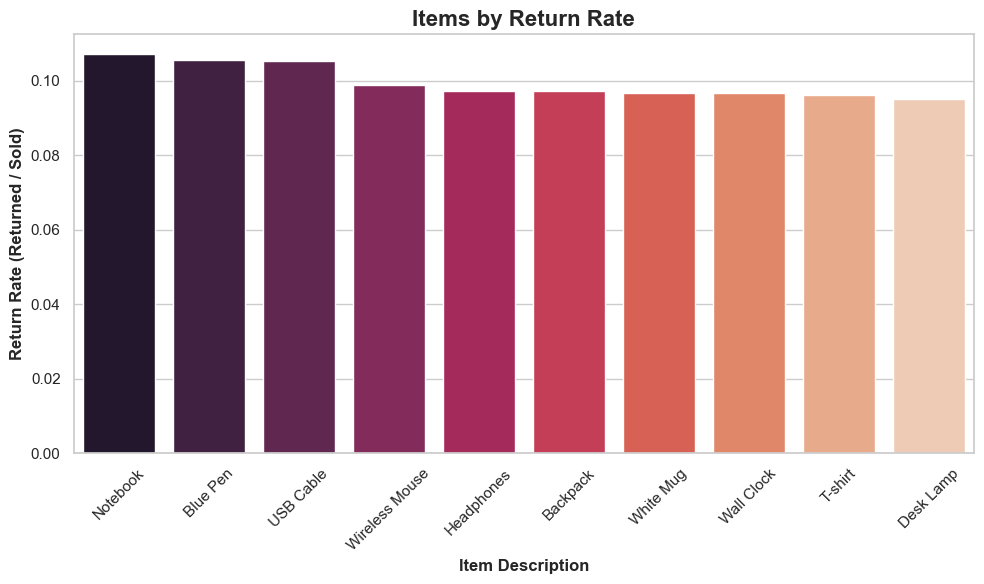

In [56]:
# 6.4 Return Rate Bar Plot

# Calculate the return rate
combined['ReturnRate'] = combined['ReturnedQuantity'] / combined['SoldQuantity']
combined['ReturnRate'] = combined['ReturnRate'].fillna(0)

# Sort by return rate
return_rate = combined.sort_values(by='ReturnRate', ascending=False)

# Set a Seaborn theme for a cleaner look
sns.set_theme(style="whitegrid")

# Create a figure and axes
plt.figure(figsize=(10,6))

# Create the barplot using the 'mako' palette
sns.barplot(
    x='Description',
    y='ReturnRate',
    data=return_rate.head(10),
    dodge=False,
    palette="rocket"
)

# Turn off gridlines
ax.grid(False)

# Customize plot
plt.xlabel("Item Description", weight='bold')
plt.ylabel("Return Rate (Returned / Sold)", weight='bold')
plt.title("Items by Return Rate", fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations:
- The bar chart shows Notebook has the highest return rate, while Desk Lamp is on the lower end.
- Overall, return rates across items range within a few percentage points, suggesting there’s no single extreme outlier.
- Takeaway: Returns are relatively evenly distributed among products, though certain items (e.g., Notebook) see a slightly higher proportion of returns.

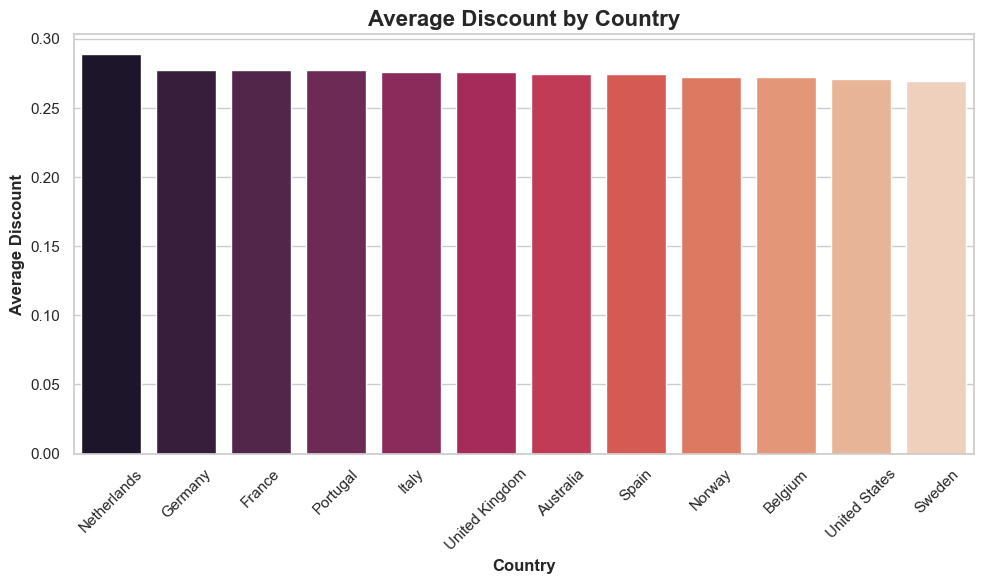

In [57]:
# 6.5 Average Discount by Country (Bar Chart)

# Group by 'Country' and calculate the mean discount
avg_discount_country = df.groupby('Country')['Discount'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_discount_country.index, y=avg_discount_country.values, palette="rocket")
plt.xlabel("Country", weight='bold')
plt.ylabel("Average Discount", weight='bold')
plt.title("Average Discount by Country", fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations:
- Netherlands and Germany offer the highest average discounts, while Sweden and the United States are at the lower end.
- The differences among countries could reflect varying promotional strategies, tax rules, or localized pricing policies.
- Takeaway: Geographical pricing differences exist, with some European markets applying more aggressive discounts than others.

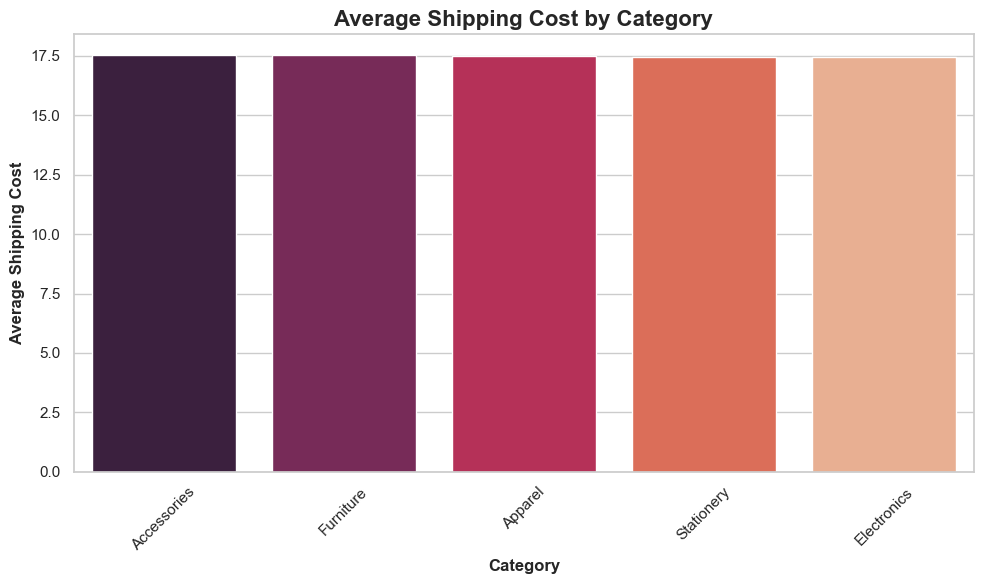

In [58]:
# 6.6 Average Shipping Cost by Category (Bar Chart)

# Group by 'Category' and calculate the mean shipping cost
avg_shipping_cost_cat = df.groupby('Category')['ShippingCost'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_shipping_cost_cat.index, y=avg_shipping_cost_cat.values, palette="rocket")
plt.xlabel("Category", weight='bold')
plt.ylabel("Average Shipping Cost", weight='bold')
plt.title("Average Shipping Cost by Category", fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations:
- Electronics has the highest average shipping cost, closely followed by Stationery and Furniture.
- Accessories is the least expensive to ship, likely due to smaller or lighter products.
- Takeaway: Heavier or more fragile product categories (like electronics or large furniture items) incur higher shipping costs, while smaller items cost less.

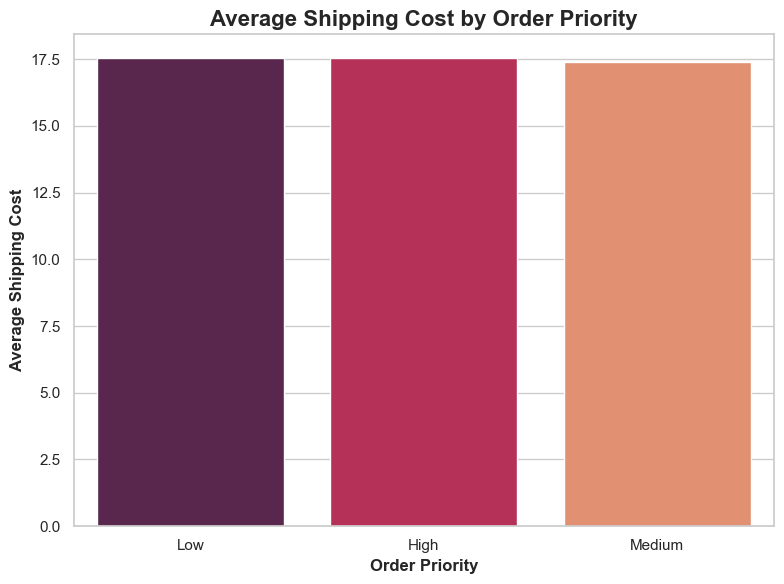

In [59]:
# 6.7 Average Shipping Cost by Order Priority (Bar Chart)

# Group by 'OrderPriority' and calculate the mean shipping cost
avg_shipping_cost_priority = df.groupby('OrderPriority')['ShippingCost'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=avg_shipping_cost_priority.index, y=avg_shipping_cost_priority.values, palette="rocket")
plt.xlabel("Order Priority", weight='bold')
plt.ylabel("Average Shipping Cost", weight='bold')
plt.title("Average Shipping Cost by Order Priority", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

### Observations:
- High priority orders show a slightly higher shipping cost, consistent with expedited shipping or premium handling fees.
- Low and Medium priority orders are cheaper, though the difference across priorities is not large.
- Takeaway: While shipping cost does rise for higher-priority orders, the gap is not dramatically large, suggesting only moderate upcharges for faster service.

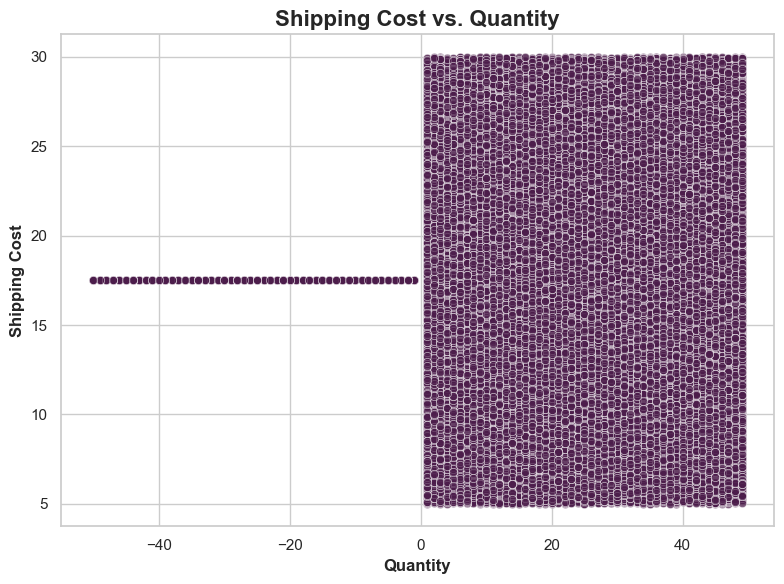

In [62]:
# 6.8 Shipping Cost vs. Quantity (Scatter Plot)
plt.figure(figsize=(8,6))
sns.scatterplot(x='Quantity', y='ShippingCost', data=df, color=rocket_colors[0], alpha=0.7)
plt.xlabel("Quantity", weight='bold')
plt.ylabel("Shipping Cost", weight='bold')
plt.title("Shipping Cost vs. Quantity", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

### Observations:
- No strong linear relationship is visible. Shipping costs vary from about 0 to 30, but the quantity axis shows a dense cluster from 0 to 50.
- A small cluster of negative quantities (likely returns) appears with a constant shipping cost.
- Takeaway: Quantity alone does not drive shipping cost significantly. Other factors—such as distance, item weight, or shipping method—likely play a larger role in determining final shipping fees.